# 미니 프로젝트

In [1]:
# 라이브러리 import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 데이터 불러오기

In [2]:
import pandas as pd

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
ap = pd.read_csv(url)
print(ap.head())

     Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121


In [3]:
# Month컬럼 제거
ap = ap.drop('Month', axis=1)

In [4]:
ap

,Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


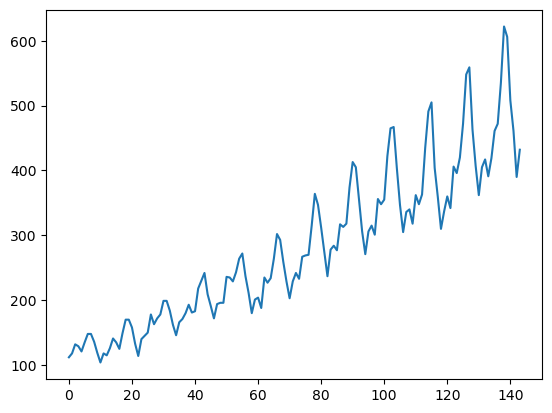

In [5]:
plt.figure()
plt.plot(ap)
plt.show()

## 비정상성 -> 정상성
### 분산을 일정하게 - 로그 변환(log transformation)

In [6]:
# np.log를 통해서 log transformation
log_transformed = np.log(ap)

In [7]:
log_transformed

,Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791
...,...
139,6.406880
140,6.230481
141,6.133398
142,5.966147


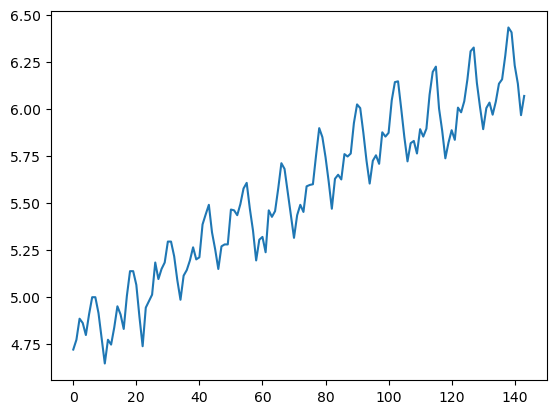

In [8]:
# 분산이 일정
plt.figure()
plt.plot(log_transformed)
plt.show()

### 차분 -> 추세 제거

❗추세 제거 이유  
- 시계열 데이터는 시간이 지날수록 계속 증가하거나 감소하는 trend가 있음.  
- 이 trend 때문에 예측 모델이 시간 흐름에만 끌려다님.  
- 차분(현재 값 - 이전 값)을 통해서 변화량만 남고 추세를 제거

🎯목적 
- 추세를 제거해서 평균이 일정한, 즉 정상성 있는 시계열로 만듦

In [9]:
# 차분
diffed = log_transformed.diff()

In [10]:
diffed

,Passengers
0,NaN
1,0.052186
2,0.112117
3,-0.022990
4,-0.064022
...,...
139,-0.026060
140,-0.176399
141,-0.097083
142,-0.167251


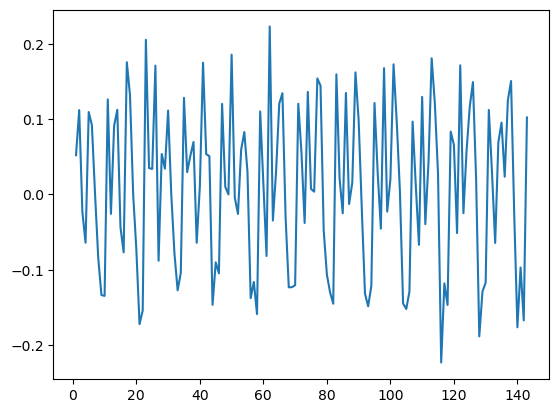

In [11]:
# 커지는 분산과 증가하는 추세를 제거한 air passengers 데이터를 얻을 수 있다.
plt.figure()
plt.plot(diffed)
plt.show()

### 계절 차분

In [12]:
# diff에 12라는 값을 넣어주면 주기를 12로 하는 계절 차분을 수행
seasonally_diffed = diffed.diff(12)
# 차분으로 생긴 결측치 제거
seasonally_diffed.dropna(inplace = True)

바로 이전 값을 빼는 것이므로 맨 첫 번째 값은 차분할 수 있는 이전 값이 없어서 Nan값이 생김.  
이를 제거해 주어야 함.

In [13]:
seasonally_diffed

,Passengers
13,0.039164
14,0.000361
15,-0.020496
16,-0.012939
17,0.066148
...,...
139,-0.045934
140,0.012024
141,0.031830
142,-0.050082


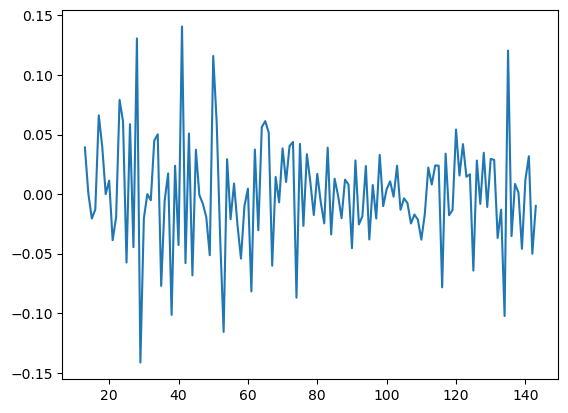

In [14]:
# 로그 변환과 차분한 데이터 시각화
plt.figure()
plt.plot(seasonally_diffed)
plt.show()

## 검정

In [15]:
from statsmodels.tsa.stattools import adfuller

def adf_test(x): # adf검정을 위한 함수 정의
    stat, p_value, lags, nobs, crit, icb = adfuller(x) # adfuller 함수를 이용하면 6가지 output
    print('ADF statistics')
    print(stat) # ADF 검정 통계량
    print('-'*15)
    print('P-value')
    print(p_value) # P-value

In [16]:
# 로그 변환 + 차분 + 계절 차분 수행한 데이터로 adf 테스트
adf_test(seasonally_diffed)

ADF statistics
-4.443324941831145
---------------
P-value
0.00024859123113838257


- p-value < 유의수준 : 대립가설 채택, 귀무가설 기각

유의수준 0.01에서 시계열에 단위근이 존재한다라는 귀무가설을 기각하고,  
시계열은 정상적이다라는 대립가설을 채택

## 데이터 불러오기

In [17]:
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

# robot exection failures 데이터
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

In [18]:
# 데이터셋 확인(timeseries와 y 확인)
timeseries # id, time을 제외하고 6개 column의 X변수

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5


In [19]:
y

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

In [20]:
# 데이터셋 가공
def custom_classification_split(x,y,test_size=0.3):

    num_true = int(y.sum()*test_size)
    num_false = int((len(y)-y.sum())*test_size)

    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()
    print(id_list)
    y_train = y.drop(id_list)                            
    y_test = y.iloc[id_list].sort_index()                
    X_train = x[~x['id'].isin(id_list)]
    X_test = x[x['id'].isin(id_list)]

    return X_train, y_train, X_test, y_test

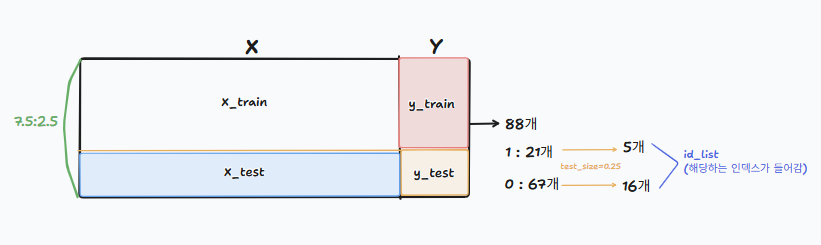

In [21]:
# 데이터셋 나누기
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y, test_size=0.25)

[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 1, 2, 3, 4, 5]


In [22]:
# [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 1, 2, 3, 4, 5]
# [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 1, 2, 3, 4, 5, 6]

In [23]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

settings = EfficientFCParameters()

EfficientParameters는 큰 계산비용이 필요한 calculator를 제외하고 가능한 모든 피처 생성

In [24]:
# Feature extraction
comprehensive_features_train = extract_features(
                                    X_train,
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.09s/it]


In [25]:
comprehensive_features_test = extract_features(
                                    X_test,
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.50it/s]


In [26]:
# impute 전처리 함수
impute(comprehensive_features_train)

C:\Users\juwonhee\Anaconda3\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
6,1.0,1.0,1.0,1.0,-15.0,39.0,1.714286,0.142857,0.153846,-1.0,...,0.974315,1.213008,1.732868,1.438883,1.863680,2.145842,2.163956,2.197225,0.0,0.714286
7,0.0,1.0,0.0,1.0,-13.0,21.0,0.928571,0.214286,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.043794,1.349792,1.666333,1.748067,1.831020,0.0,0.428571
8,1.0,0.0,1.0,1.0,-10.0,26.0,1.142857,-0.142857,0.192308,-1.0,...,1.494175,1.732868,2.079442,1.412745,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
9,1.0,0.0,0.0,1.0,-10.0,24.0,1.428571,0.000000,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.479133,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
10,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,0.000000,-1.0,...,0.937285,1.213008,1.906155,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1.0,1.0,0.0,1.0,-1073.0,96833.0,7.142857,-5.428571,-0.038462,-98.0,...,0.735622,0.735622,1.386294,1.585771,2.253858,2.397895,2.302585,2.197225,0.0,24.285714
85,1.0,0.0,1.0,1.0,143.0,1683.0,1.357143,1.071429,0.076923,8.0,...,0.735622,0.735622,1.667462,1.332245,1.589027,1.893788,2.163956,2.197225,0.0,5.571429
86,1.0,0.0,0.0,0.0,961.0,83497.0,9.071429,9.071429,0.807692,52.0,...,0.735622,1.073543,1.732868,0.687092,0.983088,1.159589,1.227529,1.303092,0.0,9.285714
87,1.0,1.0,0.0,1.0,4509.0,1405437.0,12.928571,12.214286,-1.038462,338.0,...,0.735622,0.735622,1.386294,0.535961,0.836988,1.159589,1.497866,1.581094,0.0,40.285714


In [27]:
impute(comprehensive_features_test)

C:\Users\juwonhee\Anaconda3\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,-0.038462,-1.0,...,1.073543,1.440235,2.079442,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.000000,-0.038462,-1.0,...,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.831020,0.0,0.571429
3,0.0,0.0,1.0,1.0,-10.0,12.0,0.714286,0.000000,-0.038462,-1.0,...,1.386294,1.732868,2.079442,1.265857,1.704551,2.019815,2.163956,2.197225,0.0,0.571429
4,0.0,1.0,1.0,1.0,-6.0,16.0,1.214286,-0.071429,-0.038462,0.0,...,1.073543,1.494175,2.079442,1.156988,1.907284,2.397895,2.302585,2.197225,0.0,1.000000
5,0.0,0.0,0.0,1.0,-9.0,17.0,0.928571,-0.071429,0.038462,-1.0,...,0.900256,1.320888,2.079442,1.156988,1.863680,2.271869,2.302585,2.197225,0.0,0.857143
19,1.0,0.0,0.0,1.0,99.0,6109.0,13.928571,-1.928571,-1.730769,1.0,...,0.974315,1.494175,1.906155,1.230932,1.704551,2.019815,2.025326,2.043192,0.0,1.428571
20,1.0,0.0,1.0,1.0,155.0,34455.0,16.714286,-13.142857,7.576923,-1.0,...,1.386294,1.667462,2.079442,1.564957,2.022809,2.271869,2.302585,2.197225,0.0,2.571429
21,1.0,0.0,0.0,1.0,-171.0,16495.0,20.928571,1.785714,3.961538,-1.0,...,0.735622,0.735622,0.735622,1.303876,1.791759,2.271869,2.302585,2.197225,0.0,17.285714
22,1.0,0.0,0.0,1.0,102.0,12700.0,10.785714,-8.071429,4.500000,-1.0,...,0.562335,0.735622,1.732868,1.524707,2.138333,2.397895,2.302585,2.197225,0.0,5.428571
23,1.0,0.0,0.0,1.0,67.0,10593.0,15.142857,-7.000000,3.000000,-3.0,...,0.974315,1.255482,2.079442,1.519383,2.369382,2.397895,2.302585,2.197225,0.0,3.714286


### RandomForest

In [30]:
# RandomForest 사용 및 score 확인
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10, max_depth = 3)

rf_clf.fit(comprehensive_features_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10)

In [31]:
rf_clf.score(comprehensive_features_test, y_test)

1.0

test_size: 0.3  -> 약 0.666  
test셋에 적합해본 결과 약 0.66의 정확도를 보이며 불만족스러운 결과를 확인  
  
test_size: 0.25 -> 약0.904 

### XGBoost

In [32]:
# XGBoost 사용 및 score 확인
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators = 10, max_depth = 3)

# XGBoost 모델을 학습
xgb_clf.fit(comprehensive_features_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=10,
              n_jobs=None, num_parallel_tree=None, ...)

In [33]:
# XGBoost 모델의 score를 확인
xgb_clf.score(comprehensive_features_test, y_test)

1.0

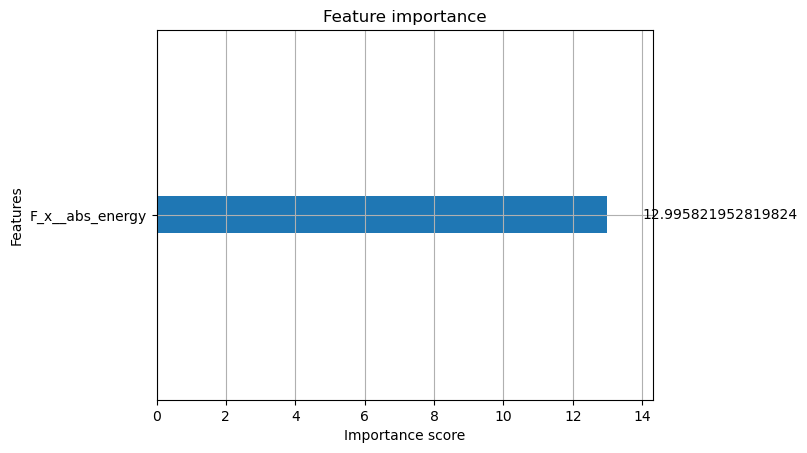

In [34]:
# XGBoost plot_importance 확인 및 시각화
# plot_importance를 통해 어떤 변수(특징)가 가장 유의미한지 확인
xgb.plot_importance(xgb_clf, importance_type = 'gain')
plt.show()

In [35]:
sum(xgb_clf.feature_importances_ != 0) # Fx 값의 abs_energy 특징만의 유의미함

1

In [36]:
# Classification report를 통한 검증 및 분석
from sklearn.metrics import classification_report

classification_report(y_test, xgb_clf.predict(comprehensive_features_test), target_names = ['true', 'false'], output_dict = True)

{'true': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16.0},
 'false': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21.0}}

## DecisionTreeClassifier

In [47]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(max_depth = 3) # 모델 선택

dt_clf.fit(comprehensive_features_train, y_train) # 모델 학습
dt_clf.score(comprehensive_features_test, y_test)

0.8095238095238095

In [48]:
# Classification report를 통한 검증 및 분석
from sklearn.metrics import classification_report

classification_report(y_test, dt_clf.predict(comprehensive_features_test), target_names = ['true', 'false'], output_dict = True)

{'true': {'precision': 1.0,
  'recall': 0.75,
  'f1-score': 0.8571428571428571,
  'support': 16.0},
 'false': {'precision': 0.5555555555555556,
  'recall': 1.0,
  'f1-score': 0.7142857142857143,
  'support': 5.0},
 'accuracy': 0.8095238095238095,
 'macro avg': {'precision': 0.7777777777777778,
  'recall': 0.875,
  'f1-score': 0.7857142857142857,
  'support': 21.0},
 'weighted avg': {'precision': 0.8941798941798942,
  'recall': 0.8095238095238095,
  'f1-score': 0.8231292517006802,
  'support': 21.0}}

## LightGBM

In [55]:
# 특수문자 제거
comprehensive_features_train.columns = comprehensive_features_train.columns.str.replace(r'[^A-Za-z0-9_]', '_', regex=True)
comprehensive_features_test.columns = comprehensive_features_test.columns.str.replace(r'[^A-Za-z0-9_]', '_', regex=True)

In [56]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier()

lgbm_clf.fit(comprehensive_features_train, y_train)
lgbm_clf.score(comprehensive_features_test, y_test)

[LightGBM] [Info] Number of positive: 16, number of negative: 51
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35670
[LightGBM] [Info] Number of data points in the train set: 67, number of used features: 1841
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238806 -> initscore=-1.159237
[LightGBM] [Info] Start training from score -1.159237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

1.0

In [57]:
# Classification report를 통한 검증 및 분석
from sklearn.metrics import classification_report

classification_report(y_test, lgbm_clf.predict(comprehensive_features_test), target_names = ['true', 'false'], output_dict = True)

{'true': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16.0},
 'false': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21.0}}

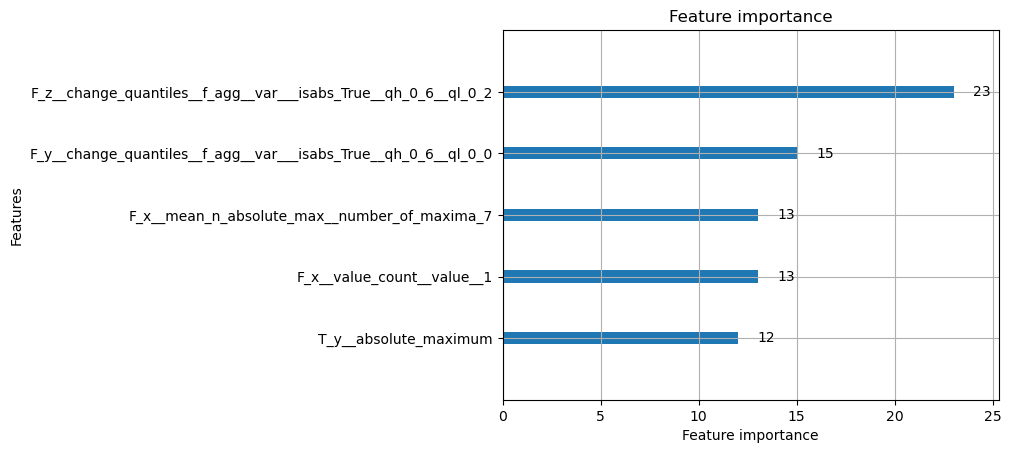

In [66]:
import lightgbm as lgb
import matplotlib.pyplot as plt

lgb.plot_importance(lgbm_clf, max_num_features=5)
plt.show()

F_z 시계열에서 중간값 구간(20~60% 분위수)의 절대 변화량 분산 이 가장 영향을 많이 미치는 컬럼이다.